# Exploring local and remote sensing datasets for Paracou

Load Google Earth Engine Python API with other packages

In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ee
import geemap
from IPython.display import Image
ee.Initialize()

## Analysis of MODIS EVI

In [ ]:
#ft = IMPORT FLUX TOWER LOCATION

In [2]:
paracou = ee.Geometry.Polygon(
    [
        [
            [-52.96826251951243, 5.255075746627255],
            [-52.91770824399973, 5.255075746627255],
            [-52.91770824399973, 5.307808451724001],
            [-52.96826251951243, 5.307808451724001],
            [-52.96826251951243, 5.255075746627255],
        ]
    ]
)
# Function to extract dates and EVI from images in image collection
def EVI_dates(image):
    date = image.date().format('YYYY-MM-dd')
    dict = image.reduceRegion(ee.Reducer.mean(), paracou)
    dict2 = ee.Feature(None, dict.set('date', date))
    return dict2

In [3]:
# Break time series into two parts so that data can be loaded locally from GEE
py_date0 = dt.datetime(2000, 1, 1)
py_date1 = dt.datetime(2010, 1, 1)
py_date2 =dt.datetime(2021, 1, 1)

dates = [py_date0, py_date1, py_date2]

In [4]:
# Retrieving and formatting EVI data looping over given dates
EVI = pd.DataFrame([])
for i in range(len(dates)-1):
    start_date = ee.Date(dates[i])
    print(dates[i])
    end_date = ee.Date(dates[i+1])
    print(dates[i+1])
    MODIS_EVI16 = (ee.ImageCollection('MODIS/MCD43A4_006_EVI')
                .filter(ee.Filter.date(start_date, end_date))
                .select('EVI'))
    info = MODIS_EVI16.map(EVI_dates).getInfo()
    EVI_local = ['i']*len(info['features'])
    for i in range(len(info['features'])):
        EVI_local[i] = info['features'][i]['properties']
    EVI_local = pd.DataFrame(EVI_local)
    EVI_local['date'] = pd.to_datetime(EVI_local['date'], format = "%Y-%m-%d")
    EVI_local.index = pd.DatetimeIndex(EVI_local['date'])
    EVI_local = EVI_local.drop('date', axis=1)
    EVI = EVI.append(EVI_local)

del(EVI_local)
print(EVI)


2000-01-01 00:00:00
2010-01-01 00:00:00
2010-01-01 00:00:00
2021-01-01 00:00:00
                 EVI
date                
2000-02-24       NaN
2000-02-25       NaN
2000-02-26       NaN
2000-02-27       NaN
2000-02-28       NaN
...              ...
2020-07-07  0.487846
2020-07-08  0.488366
2020-07-09  0.492038
2020-07-10  0.492832
2020-07-11  0.502164

[7442 rows x 1 columns]


In [17]:
# Filter dates (2000-2006 quite incomplete)
EVI_filt = EVI['2003-01-01':'2018-12-31']

In [18]:
# Interpolate missing data for upcoming decomposition
EVI_inter = EVI_filt.interpolate()
#EVI_inter = EVI.dropna()

### Seasonal decomposition of EVI
To extract seasonal EVI pattern and trend

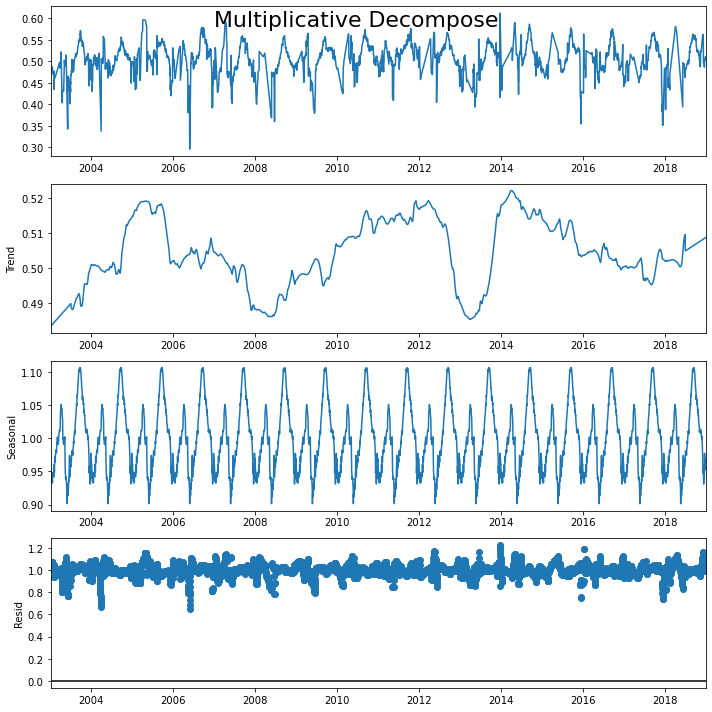

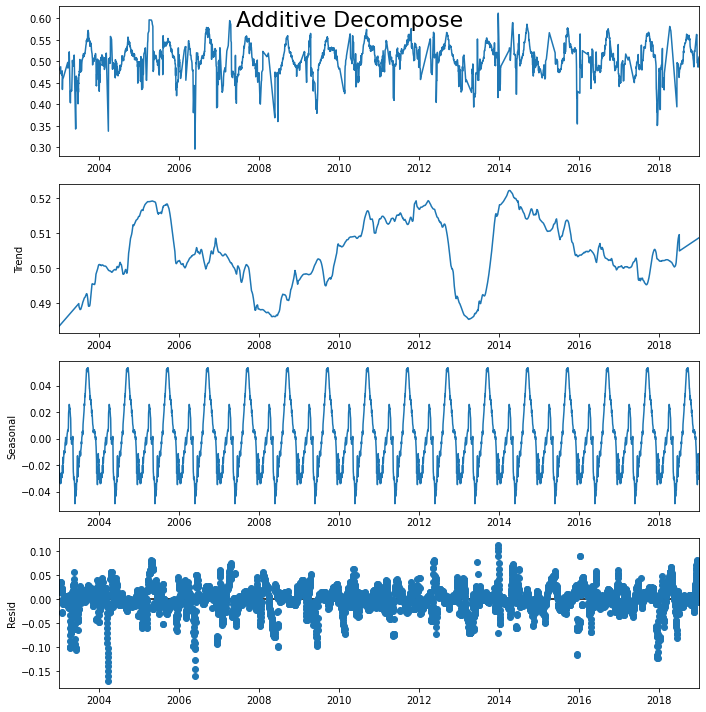

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.relativedelta import relativedelta
from dateutil.parser import parse

# Multiplicative Decomposition 
result_mul = seasonal_decompose(EVI_inter, model='multiplicative', period = 365, extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(EVI_inter, model='additive', period = 365,extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

In [111]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [20]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window, min_periods=1).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

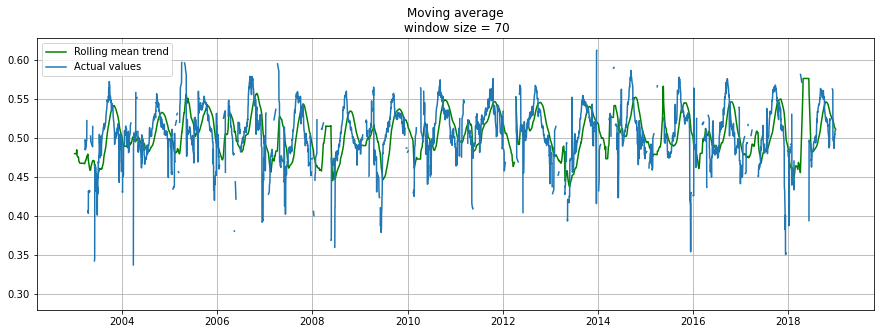

In [23]:
plotMovingAverage(EVI_filt, 70)

# Flux tower data

In [24]:
ftdata = pd.read_csv("../data/fluxtower/combined_xlsx_Fmv_Cov.csv")

In [25]:
ftdata = ftdata.drop('Unnamed: 0', axis=1)
ftdata['DateTime'] = pd.to_datetime(ftdata['DateTime'])

In [26]:
ftdata = ftdata.set_index('DateTime')


In [27]:
ftdata_flt = ftdata['2000':'2018']

In [249]:
ftdata_flt

,Unnamed: 0,Year,Month,Julian.Day,Hour.min,time,Temp.55.,Hr.55.,Hr.55.corr,Temp.30.,...,Doy,DecTim,Mean_Windsp,U.star,Wind.Direc,L,h,FileName.Fmv,SigmaV,FileName.Cov
DateTime,,,,,,,,,,,,,,,,,,,,,
2004-01-01 00:00:00,1,2004.0,1.0,1.0,0.0,1.000000,24.41000,95.00000,97.873619,24.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-01-01 00:30:00,2,2004.0,1.0,1.0,0.5,1.020833,24.61000,94.30000,97.075014,24.41,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-01-01 01:00:00,3,2004.0,1.0,1.0,1.0,1.041667,24.66000,94.10000,96.846841,24.44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-01-01 01:30:00,4,2004.0,1.0,1.0,1.5,1.062500,24.73000,94.20000,96.960928,24.44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-01-01 02:00:00,5,2004.0,1.0,1.0,2.0,1.083333,24.81000,94.10000,96.846841,24.57,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 21:30:00,262988,2018.0,12.0,365.0,21.5,365.895833,23.91000,91.45999,91.459990,24.22,...,365.0,21.5,3.2217,0.19994,146.92,54.835965,542.368887,./data/RESU2018FMV/Tob1_18-218-365_Fmv.csv,0.458203,./data/RESU2018FMV/Tob1_18-218-365_Cov.csv
2018-12-31 22:00:00,262989,2018.0,12.0,365.0,22.0,365.916667,23.83333,89.45333,89.453330,24.34,...,365.0,22.0,3.4955,0.20128,144.82,48.426150,511.390273,./data/RESU2018FMV/Tob1_18-218-365_Fmv.csv,0.514519,./data/RESU2018FMV/Tob1_18-218-365_Cov.csv
2018-12-31 22:30:00,262990,2018.0,12.0,365.0,22.5,365.937500,23.79333,88.14999,88.149990,24.21,...,365.0,22.5,3.6043,0.23745,143.28,77.870118,704.342157,./data/RESU2018FMV/Tob1_18-218-365_Fmv.csv,0.469020,./data/RESU2018FMV/Tob1_18-218-365_Cov.csv


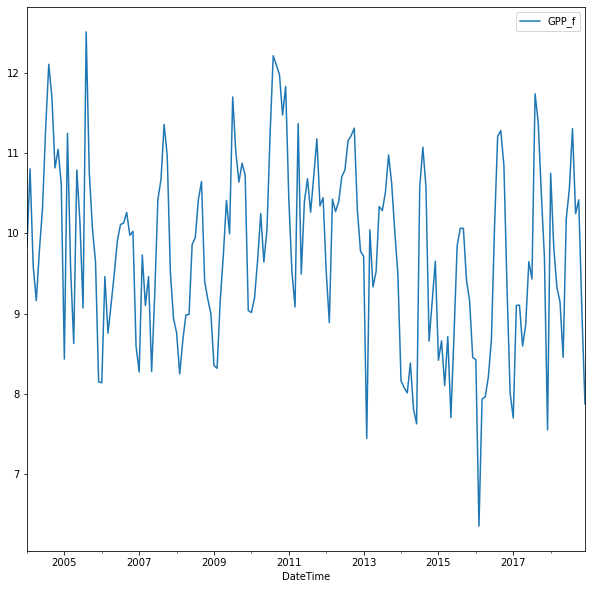

In [28]:
ftdata_flt.resample('M').mean().plot(y='GPP_f')

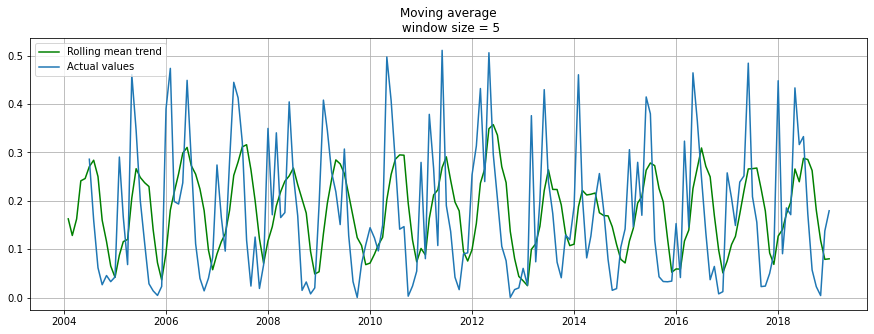

In [250]:
plotMovingAverage(ftdata_flt['Rain'].resample('M').mean(), 5)

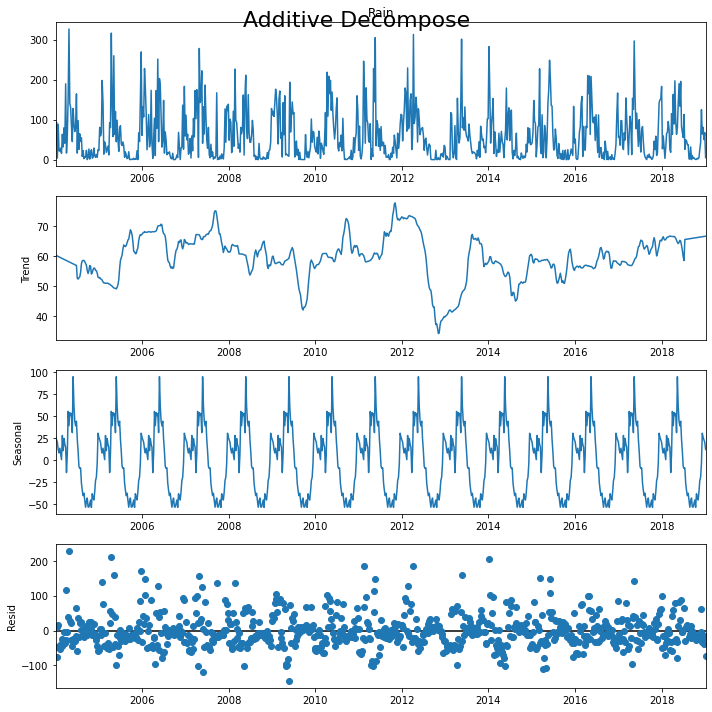

In [262]:
# Multiplicative Decomposition 
#result_mul = seasonal_decompose(ftdata_flt['GPP_f'].resample('W').sum(), model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(ftdata_flt['Rain'].resample('W').sum(), model='additive',extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
#result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

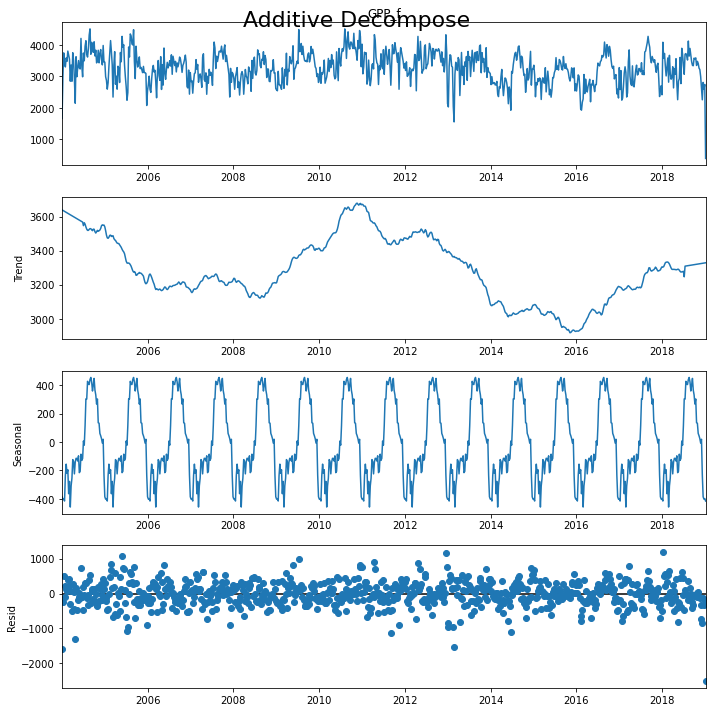

In [252]:
# Multiplicative Decomposition 
#result_mul = seasonal_decompose(ftdata_flt['GPP_f'].resample('W').sum(), model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(ftdata_flt['GPP_f'].resample('W').sum(), model='additive',extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
#result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

In [ ]:
# Multiplicative Decomposition 
#result_mul = seasonal_decompose(ftdata_flt['GPP_f'].resample('W').sum(), model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(ftdata_flt['GPP_f'].resample('W').sum(), model='additive',extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
#result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

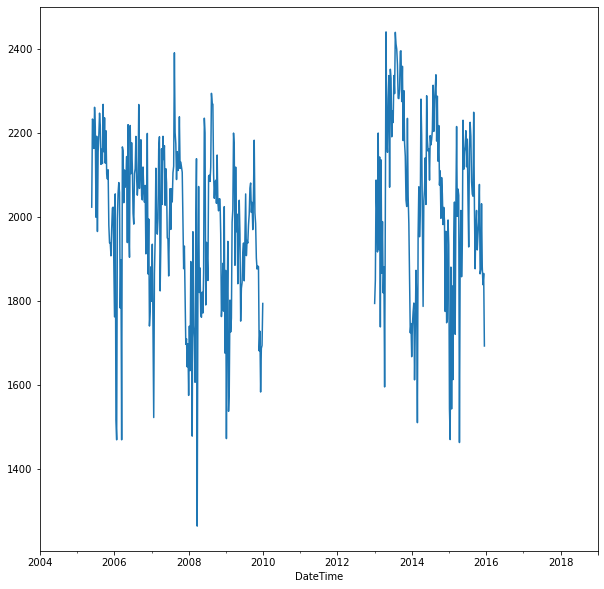

In [34]:
ftdata_flt['PAR_total'].resample('W').max().plot()